In [1]:
import pandas as pd
import numpy as np
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
# Definition of paths
data_dir = os.path.join(os.getcwd(), '../Dataset')

raw_data_dir = os.path.join(data_dir, 'raw')
ids_mapping = os.path.join(raw_data_dir, 'IDS_mapping.csv')
diabetes_data = os.path.join(raw_data_dir, 'diabetic_data.csv')

mapping_data_dir = os.path.join(data_dir, 'Mapping')
os.makedirs(mapping_data_dir, exist_ok=True)

preprocessed_out_dir = os.path.join(data_dir, 'Preprocessed')
os.makedirs(preprocessed_out_dir, exist_ok=True)

admission_type_mapping_data = os.path.join(mapping_data_dir, 'admission_type_mapping.csv')
discharge_disposition_data = os.path.join(mapping_data_dir, 'discharge_disposition_mapping.csv')
admission_source_mapping_data = os.path.join(mapping_data_dir, 'admission_source_mapping.csv')

preprocessed_saved_filepath = os.path.join(preprocessed_out_dir, 'preprocessed.pkl')

In [3]:
df = pd.read_pickle(preprocessed_saved_filepath)

In [157]:
df.describe()

,encounter_id,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin
count,6.998700e+04,6.998700e+04,69987.000000,69987.000000,69987.000000,69987.000000,69987.000000,69987.000000,69987.000000,69987.000000,69987.000000,69987.000000,69987.000000,69987.000000,69987.000000,69987.000000,69987.000000,69987.000000,69987.000000,69987.000000
mean,1.566715e+08,5.494604e+07,4.273336,42.875863,1.425379,15.665281,0.279595,0.103905,0.176276,7.224170,0.081572,0.402789,0.212439,0.013317,0.052238,0.126309,0.107920,0.075457,0.066355,0.397945
std,1.003908e+08,3.948832e+07,2.933987,19.894291,1.757003,8.287321,1.064108,0.511832,0.601633,2.001257,0.403371,0.925923,0.451194,0.126368,0.244886,0.370585,0.354595,0.277787,0.260461,0.801595
min,1.252200e+04,1.350000e+02,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,8.130386e+07,2.334223e+07,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.438693e+08,4.798360e+07,3.000000,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.153807e+08,8.749848e+07,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,4.438672e+08,1.895026e+08,14.000000,132.000000,6.000000,81.000000,42.000000,42.000000,12.000000,16.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [4]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin', 'change', 'diabetesMed', 'readmitted',
       'age-binned', 'max_glu_serum_measured', 'A1Cresult_measured',
       'repaglinide_measured', 'glimepiride_measured',
       'rosiglitazone_measured', 'pioglitazone_measured', 'glyburide_measured',
       'glipizide_measured', 'metformin_measured', 'insulin_measured'],
      dtype='object')

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69987 entries, 0 to 101765
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   encounter_id              69987 non-null  int64   
 1   patient_nbr               69987 non-null  int64   
 2   race                      69987 non-null  category
 3   gender                    69987 non-null  object  
 4   age                       69987 non-null  object  
 5   admission_type_id         69987 non-null  category
 6   discharge_disposition_id  69987 non-null  category
 7   admission_source_id       69987 non-null  category
 8   time_in_hospital          69987 non-null  int64   
 9   medical_specialty         69987 non-null  category
 10  num_lab_procedures        69987 non-null  int64   
 11  num_procedures            69987 non-null  int64   
 12  num_medications           69987 non-null  int64   
 13  number_outpatient         69987 non-null  int64   

In [160]:
df.select_dtypes(include = 'int64').columns

Index(['encounter_id', 'patient_nbr', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'glimepiride',
       'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin'],
      dtype='object')

In [161]:
df.select_dtypes(include = 'category').columns

Index(['race', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'medical_specialty', 'diag_1', 'diag_2',
       'diag_3', 'change', 'diabetesMed', 'readmitted', 'age-binned',
       'max_glu_serum_measured', 'A1Cresult_measured', 'repaglinide_measured',
       'glimepiride_measured', 'rosiglitazone_measured',
       'pioglitazone_measured', 'glyburide_measured', 'glipizide_measured',
       'metformin_measured', 'insulin_measured'],
      dtype='object')

In [162]:
# Define the ordinal mapping
label_mapping = {
    '0-30': 1,
    '30-40': 2,
    '40-50': 3,
    '50-60': 4,
    '60-70': 5,
    '70-80': 6,
    '80-90': 7,
    '90-100': 8
}

df['age'] = df['age-binned'].map(label_mapping)
df['age'] = df['age'].astype('int64')
df = df.drop(columns= ['age-binned'])

In [163]:
df['gender'] = df['gender'].astype('category')

In [164]:
columnsToDrop = ['repaglinide_measured',
       'glimepiride_measured', 'rosiglitazone_measured',
       'pioglitazone_measured', 'glyburide_measured', 'glipizide_measured',
       'metformin_measured', 'insulin_measured', 'metformin', 'repaglinide', 'glimepiride',
       'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin']
df = df.drop(columns = columnsToDrop)

In [165]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'change',
       'diabetesMed', 'readmitted', 'max_glu_serum_measured',
       'A1Cresult_measured'],
      dtype='object')

In [166]:
columnsToDrop = ['encounter_id', 'patient_nbr', 'race', 'admission_type_id', 'medical_specialty', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3',]
df = df.drop(columns = columnsToDrop)

In [167]:
df.columns

Index(['gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed', 'readmitted',
       'max_glu_serum_measured', 'A1Cresult_measured'],
      dtype='object')

In [168]:
yes_no_columns = [col for col in df.columns if df[col].nunique() == 2 and sorted(df[col].unique()) == ['NO', 'YES']]
for col in yes_no_columns:
    df[col] = df[col].map({'NO': 0, 'YES': 1})

In [169]:
# Split features and target
target_column = 'readmitted'  # Specify the target column
X = df.drop(columns=[target_column])
y = df[target_column]


In [170]:
# Identify categorical, binary, and numerical columns
categorical_columns = X.select_dtypes(include=['category']).columns.tolist()
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [171]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69987 entries, 0 to 101765
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   gender                  69987 non-null  category
 1   age                     69987 non-null  int64   
 2   time_in_hospital        69987 non-null  int64   
 3   num_lab_procedures      69987 non-null  int64   
 4   num_procedures          69987 non-null  int64   
 5   num_medications         69987 non-null  int64   
 6   number_outpatient       69987 non-null  int64   
 7   number_emergency        69987 non-null  int64   
 8   number_inpatient        69987 non-null  int64   
 9   number_diagnoses        69987 non-null  int64   
 10  max_glu_serum           69987 non-null  int64   
 11  A1Cresult               69987 non-null  int64   
 12  change                  69987 non-null  category
 13  diabetesMed             69987 non-null  category
 14  max_glu_serum_measured  69

In [172]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first'), categorical_columns),
        ('scaler', StandardScaler(), numerical_columns)
    ],
    remainder='passthrough'  # Leave binary columns unchanged
)

In [173]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [174]:
# Create a pipeline with preprocessing and XGBoost model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss'))
])

In [175]:
# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['gender', 'change',
                                                   'diabetesMed',
                                                   'max_glu_serum_measured',
                                                   'A1Cresult_measured']),
                                                 ('scaler', StandardScaler(),
                                                  ['age', 'time_in_hospital',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emerge...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

Confusion Matrix:
[[6888 1473]
 [3810 1827]]
Training Accuracy: 0.68
Test Accuracy: 0.62
Training Precision: 0.69
Test Precision: 0.55
Training Recall: 0.40
Test Recall: 0.32


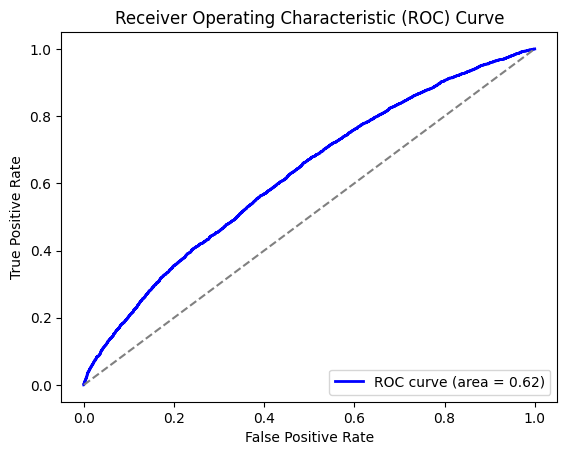

In [176]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)
train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Print metrics
print(f'Training Accuracy: {train_accuracy:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')
print(f'Training Precision: {train_precision:.2f}')
print(f'Test Precision: {test_precision:.2f}')
print(f'Training Recall: {train_recall:.2f}')
print(f'Test Recall: {test_recall:.2f}')

# Plot ROC Curve for test set
y_test_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()